# Phase 3: Baseline Models for AQI Forecasting

This notebook implements baseline models for 1-day ahead AQI forecasting in Delhi, India.

## Objectives:
1. Implement naive baseline models (Persistence, SMA, EMA, Seasonal Naive)
2. Implement ARIMA model with auto parameter selection
3. Evaluate on validation, test (2019), and test2 (2020 - COVID robustness)
4. Compare models using MAE, RMSE, MAPE, R², and AQI Category Accuracy

## Data Split:
- **Train**: 2015-2017 (3 years)
- **Validation**: 2018 (1 year)
- **Test**: 2019 (1 year) - Normal conditions
- **Test2**: 2020 (6 months) - COVID-19 robustness testing

## 1. Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical models
from pmdarima import auto_arima

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.2
NumPy version: 2.2.6


## 2. Load Datasets

In [2]:
# Define file paths (relative to project root)
data_dir = 'Data/processed'

# Load daily datasets
train_df = pd.read_csv(f'{data_dir}/delhi_train_daily.csv', parse_dates=['Date'])
val_df = pd.read_csv(f'{data_dir}/delhi_val_daily.csv', parse_dates=['Date'])
test_df = pd.read_csv(f'{data_dir}/delhi_test_daily.csv', parse_dates=['Date'])
test2_df = pd.read_csv(f'{data_dir}/delhi_test2_daily.csv', parse_dates=['Date'])

# Set Date as index
train_df.set_index('Date', inplace=True)
val_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)
test2_df.set_index('Date', inplace=True)

print("="*60)
print("DATASETS LOADED SUCCESSFULLY")
print("="*60)
print(f"\nTrain: {train_df.index.min()} to {train_df.index.max()} ({len(train_df)} records)")
print(f"Validation: {val_df.index.min()} to {val_df.index.max()} ({len(val_df)} records)")
print(f"Test: {test_df.index.min()} to {test_df.index.max()} ({len(test_df)} records)")
print(f"Test2 (COVID): {test2_df.index.min()} to {test2_df.index.max()} ({len(test2_df)} records)")

DATASETS LOADED SUCCESSFULLY

Train: 2015-01-30 00:00:00 to 2017-12-31 00:00:00 (1065 records)
Validation: 2018-01-01 00:00:00 to 2018-12-31 00:00:00 (365 records)
Test: 2019-01-01 00:00:00 to 2019-12-31 00:00:00 (365 records)
Test2 (COVID): 2020-01-01 00:00:00 to 2020-07-01 00:00:00 (183 records)


## 3. Helper Functions

In [3]:
def aqi_to_category(aqi):
    """Convert AQI value to CPCB category."""
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'

def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate model performance using multiple metrics.
    
    Returns:
        Dictionary with MAE, RMSE, MAPE, R², and Category Accuracy
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    # Category accuracy
    y_true_cat = [aqi_to_category(aqi) for aqi in y_true]
    y_pred_cat = [aqi_to_category(aqi) for aqi in y_pred]
    cat_accuracy = np.mean([1 if t == p else 0 for t, p in zip(y_true_cat, y_pred_cat)]) * 100
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2,
        'Category_Accuracy': cat_accuracy
    }

print("Evaluation function defined successfully!")

Evaluation function defined successfully!


In [4]:
def plot_temporal_predictions(model_name, test_pred, test2_pred, test_df, test2_df):
    """
    Plot actual vs predicted AQI for test periods only.
    
    Phases shown:
    - Test (2019): Actual + Predicted (normal conditions evaluation)
    - Test2 (2020): Actual + Predicted (COVID robustness evaluation)
    """
    fig, ax = plt.subplots(1, 1, figsize=(16, 5))
    
    # Plot Test: Actual + Predicted
    ax.plot(test_df.index, test_df['AQI'], 
            color='black', linewidth=2, label='Actual AQI', alpha=0.8)
    ax.plot(test_df.index, test_pred, 
            color='red', linewidth=2, linestyle='--', label='Predicted AQI', alpha=0.7)
    
    # Plot Test2: Actual + Predicted (continuation)
    ax.plot(test2_df.index, test2_df['AQI'], 
            color='black', linewidth=2, alpha=0.8)
    ax.plot(test2_df.index, test2_pred, 
            color='red', linewidth=2, linestyle='--', alpha=0.7)
    
    # Add vertical line to mark Test2 (COVID) start
    test2_start = test2_df.index.min()
    ax.axvline(test2_start, color='darkred', linestyle=':', linewidth=2.5, 
               label='COVID Period Starts (2020)', alpha=0.7)
    
    # Add shaded backgrounds for different phases
    ax.axvspan(test_df.index.min(), test_df.index.max(), alpha=0.1, color='blue')
    ax.axvspan(test2_start, test2_df.index.max(), alpha=0.15, color='red')
    
    # Add AQI category horizontal lines with labels
    ax.axhline(50, color='green', linestyle='--', linewidth=1, alpha=0.4, label='Good (0-50)')
    ax.axhline(100, color='yellow', linestyle='--', linewidth=1, alpha=0.4)
    ax.axhline(200, color='orange', linestyle='--', linewidth=1, alpha=0.4, label='Moderate (100-200)')
    ax.axhline(300, color='red', linestyle='--', linewidth=1, alpha=0.4, label='Poor (200-300)')
    ax.axhline(400, color='darkred', linestyle='--', linewidth=1, alpha=0.4)
    
    # Add text annotations for phases
    test_mid = test_df.index[len(test_df)//2]
    test2_mid = test2_df.index[len(test2_df)//2]
    ax.text(test_mid, ax.get_ylim()[1]*0.95, 'Test 2019\n(Normal Conditions)', 
            ha='center', fontsize=10, fontweight='bold', 
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    ax.text(test2_mid, ax.get_ylim()[1]*0.95, 'Test2 2020\n(COVID Period)', 
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
    
    # Formatting
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('AQI', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name}: Actual vs Predicted AQI', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Temporal visualization function defined successfully!")

Temporal visualization function defined successfully!


## 4. Naive Baseline Models

We implement the following naive models:
1. **Persistence (Naive)**: $\hat{y}_t = y_{t-1}$
2. **Simple Moving Average (SMA)**: $\hat{y}_t = \frac{1}{k}\sum_{i=1}^{k} y_{t-i}$ for k ∈ {3, 7, 14, 30}
3. **Exponential Moving Average (EMA)**: $\hat{y}_t = \alpha y_{t-1} + (1-\alpha)\hat{y}_{t-1}$ for α ∈ {0.1, 0.3, 0.5, 0.7, 0.9}
4. **Seasonal Naive**: $\hat{y}_t = y_{t-365}$ (same day previous year)

In [5]:
# Prepare data for naive models
# Combine train and val for fitting naive models, then test on test and test2
train_val_df = pd.concat([train_df, val_df])

print(f"Combined train+val: {train_val_df.index.min()} to {train_val_df.index.max()} ({len(train_val_df)} records)")

Combined train+val: 2015-01-30 00:00:00 to 2018-12-31 00:00:00 (1430 records)


### 4.1 Persistence (Naive) Model

In [6]:
def predict_persistence(data, test_data):
    """
    Persistence model: predict tomorrow's AQI = today's AQI
    """
    predictions = []
    
    # For each test point, use previous day's value
    for i in range(len(test_data)):
        if i == 0:
            # First prediction uses last value from training data
            predictions.append(data['AQI'].iloc[-1])
        else:
            # Subsequent predictions use actual previous day value
            predictions.append(test_data['AQI'].iloc[i-1])
    
    return np.array(predictions)

# Test on validation set
val_pred_persistence = predict_persistence(train_df, val_df)
val_results_persistence = evaluate_model(val_df['AQI'].values, val_pred_persistence, 'Persistence')

# Test on test set (2019)
test_pred_persistence = predict_persistence(train_val_df, test_df)
test_results_persistence = evaluate_model(test_df['AQI'].values, test_pred_persistence, 'Persistence')

# Test on test2 set (2020 - COVID)
test2_pred_persistence = predict_persistence(train_val_df, test2_df)
test2_results_persistence = evaluate_model(test2_df['AQI'].values, test2_pred_persistence, 'Persistence')

print("Persistence Model Results:")
print(f"Validation - MAE: {val_results_persistence['MAE']:.2f}, RMSE: {val_results_persistence['RMSE']:.2f}, R²: {val_results_persistence['R²']:.4f}")
print(f"Test (2019) - MAE: {test_results_persistence['MAE']:.2f}, RMSE: {test_results_persistence['RMSE']:.2f}, R²: {test_results_persistence['R²']:.4f}")
print(f"Test2 (2020) - MAE: {test2_results_persistence['MAE']:.2f}, RMSE: {test2_results_persistence['RMSE']:.2f}, R²: {test2_results_persistence['R²']:.4f}")

Persistence Model Results:
Validation - MAE: 34.37, RMSE: 47.61, R²: 0.8260
Test (2019) - MAE: 38.48, RMSE: 53.99, R²: 0.7887
Test2 (2020) - MAE: 29.26, RMSE: 39.58, R²: 0.8081


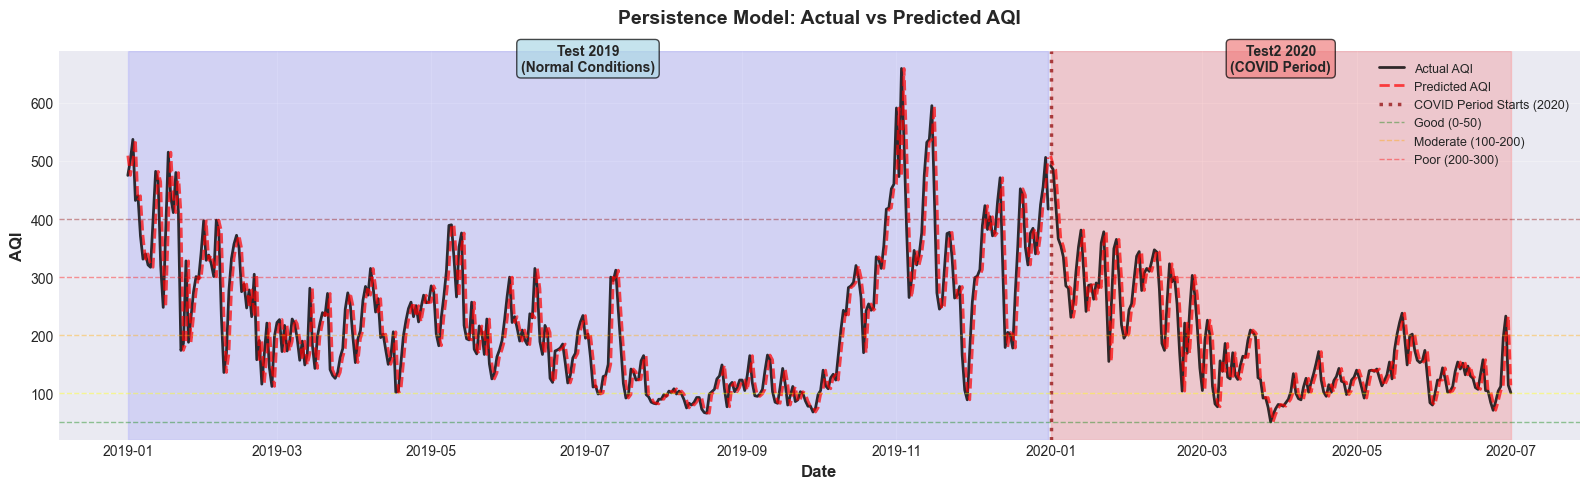

In [7]:
# Visualize Persistence Model predictions
plot_temporal_predictions(
    model_name='Persistence Model',
    test_pred=test_pred_persistence,
    test2_pred=test2_pred_persistence,
    test_df=test_df,
    test2_df=test2_df
)

### 4.2 Simple Moving Average (SMA) Models

In [8]:
def predict_sma(data, test_data, window):
    """
    Simple Moving Average: average of last 'window' values
    """
    predictions = []
    
    # Combine data for rolling window calculation
    combined = pd.concat([data, test_data])
    
    for i in range(len(data), len(combined)):
        # Calculate mean of previous 'window' values
        predictions.append(combined['AQI'].iloc[i-window:i].mean())
    
    return np.array(predictions)

# Test SMA with different window sizes
sma_windows = [3, 7, 14, 30]
sma_results = {'val': [], 'test': [], 'test2': []}

for window in sma_windows:
    model_name = f'SMA-{window}'
    
    # Validation
    val_pred = predict_sma(train_df, val_df, window)
    sma_results['val'].append(evaluate_model(val_df['AQI'].values, val_pred, model_name))
    
    # Test (2019)
    test_pred = predict_sma(train_val_df, test_df, window)
    sma_results['test'].append(evaluate_model(test_df['AQI'].values, test_pred, model_name))
    
    # Test2 (2020)
    test2_pred = predict_sma(train_val_df, test2_df, window)
    sma_results['test2'].append(evaluate_model(test2_df['AQI'].values, test2_pred, model_name))
    
    print(f"{model_name} - Test MAE: {sma_results['test'][-1]['MAE']:.2f}, RMSE: {sma_results['test'][-1]['RMSE']:.2f}, R²: {sma_results['test'][-1]['R²']:.4f}")

print("\nSMA models completed!")

SMA-3 - Test MAE: 48.49, RMSE: 66.06, R²: 0.6836
SMA-7 - Test MAE: 56.05, RMSE: 75.82, R²: 0.5831
SMA-14 - Test MAE: 59.25, RMSE: 77.99, R²: 0.5590
SMA-30 - Test MAE: 65.67, RMSE: 87.96, R²: 0.4390

SMA models completed!


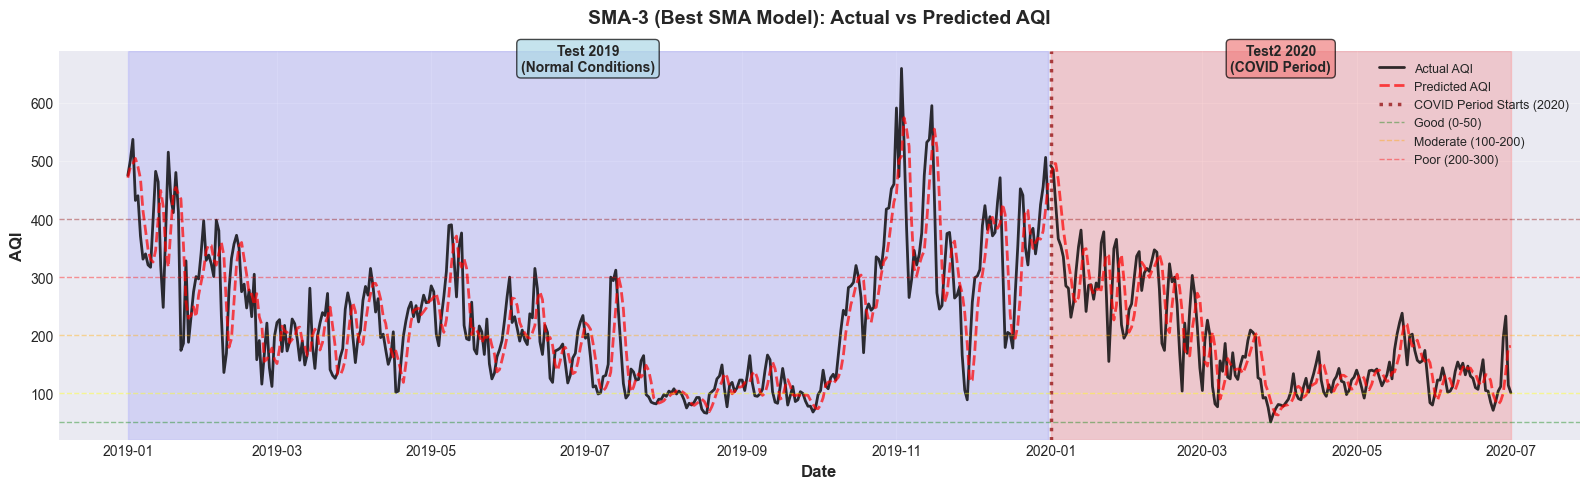

In [9]:
# Visualize Best SMA Model (SMA-3) predictions
test_pred_sma_3 = predict_sma(train_val_df, test_df, window=3)
test2_pred_sma_3 = predict_sma(train_val_df, test2_df, window=3)

plot_temporal_predictions(
    model_name='SMA-3 (Best SMA Model)',
    test_pred=test_pred_sma_3,
    test2_pred=test2_pred_sma_3,
    test_df=test_df,
    test2_df=test2_df
)

### 4.3 Exponential Moving Average (EMA) Models

In [10]:
def predict_ema(data, test_data, alpha):
    """
    Exponential Moving Average: weighted average with decay factor alpha
    Higher alpha gives more weight to recent observations
    """
    predictions = []
    
    # Initialize EMA with first training value
    ema = data['AQI'].iloc[0]
    
    # Update EMA through training data
    for val in data['AQI'].iloc[1:]:
        ema = alpha * val + (1 - alpha) * ema
    
    # Make predictions for test data
    for i in range(len(test_data)):
        predictions.append(ema)
        # Update EMA with actual value for next prediction
        ema = alpha * test_data['AQI'].iloc[i] + (1 - alpha) * ema
    
    return np.array(predictions)

# Test EMA with different alpha values
ema_alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
ema_results = {'val': [], 'test': [], 'test2': []}

for alpha in ema_alphas:
    model_name = f'EMA-{alpha}'
    
    # Validation
    val_pred = predict_ema(train_df, val_df, alpha)
    ema_results['val'].append(evaluate_model(val_df['AQI'].values, val_pred, model_name))
    
    # Test (2019)
    test_pred = predict_ema(train_val_df, test_df, alpha)
    ema_results['test'].append(evaluate_model(test_df['AQI'].values, test_pred, model_name))
    
    # Test2 (2020)
    test2_pred = predict_ema(train_val_df, test2_df, alpha)
    ema_results['test2'].append(evaluate_model(test2_df['AQI'].values, test2_pred, model_name))
    
    print(f"{model_name} - Test MAE: {ema_results['test'][-1]['MAE']:.2f}, RMSE: {ema_results['test'][-1]['RMSE']:.2f}, R²: {ema_results['test'][-1]['R²']:.4f}")

print("\nEMA models completed!")

EMA-0.1 - Test MAE: 56.12, RMSE: 75.12, R²: 0.5908
EMA-0.3 - Test MAE: 47.44, RMSE: 64.43, R²: 0.6990
EMA-0.5 - Test MAE: 43.93, RMSE: 59.34, R²: 0.7446
EMA-0.7 - Test MAE: 41.02, RMSE: 56.13, R²: 0.7716
EMA-0.9 - Test MAE: 38.87, RMSE: 54.38, R²: 0.7856

EMA models completed!


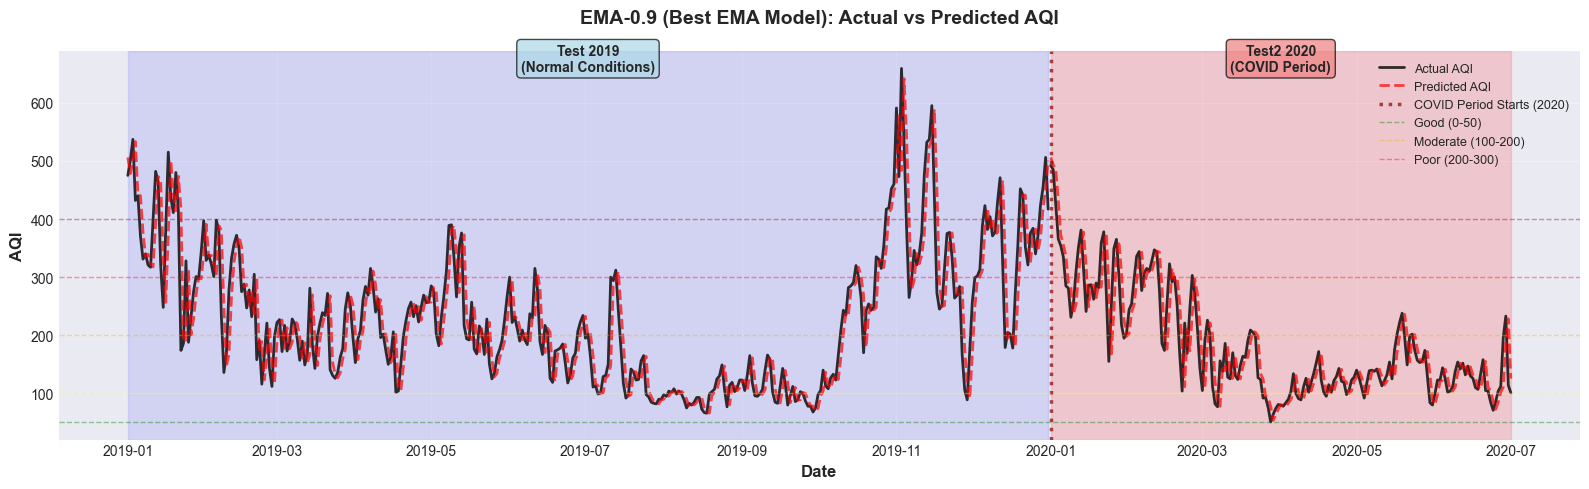

In [11]:
# Visualize Best EMA Model (EMA-0.9) predictions
test_pred_ema_09 = predict_ema(train_val_df, test_df, alpha=0.9)
test2_pred_ema_09 = predict_ema(train_val_df, test2_df, alpha=0.9)

plot_temporal_predictions(
    model_name='EMA-0.9 (Best EMA Model)',
    test_pred=test_pred_ema_09,
    test2_pred=test2_pred_ema_09,
    test_df=test_df,
    test2_df=test2_df
)

### 4.4 Seasonal Naive Model

In [12]:
def predict_seasonal_naive(data, test_data, period=365):
    """
    Seasonal Naive: predict using value from same day in previous year (period=365)
    """
    predictions = []
    
    # Combine data for seasonal lookback
    combined = pd.concat([data, test_data])
    
    for i in range(len(data), len(combined)):
        # Use value from 'period' days ago
        if i >= period:
            predictions.append(combined['AQI'].iloc[i-period])
        else:
            # Fallback to persistence if not enough history
            predictions.append(combined['AQI'].iloc[i-1])
    
    return np.array(predictions)

# Seasonal Naive with period=365 (yearly seasonality)
model_name = 'Seasonal_Naive-365'

# Validation
val_pred_seasonal = predict_seasonal_naive(train_df, val_df)
val_results_seasonal = evaluate_model(val_df['AQI'].values, val_pred_seasonal, model_name)

# Test (2019)
test_pred_seasonal = predict_seasonal_naive(train_val_df, test_df)
test_results_seasonal = evaluate_model(test_df['AQI'].values, test_pred_seasonal, model_name)

# Test2 (2020)
test2_pred_seasonal = predict_seasonal_naive(train_val_df, test2_df)
test2_results_seasonal = evaluate_model(test2_df['AQI'].values, test2_pred_seasonal, model_name)

print(f"{model_name} Results:")
print(f"Validation - MAE: {val_results_seasonal['MAE']:.2f}, RMSE: {val_results_seasonal['RMSE']:.2f}, R²: {val_results_seasonal['R²']:.4f}")
print(f"Test (2019) - MAE: {test_results_seasonal['MAE']:.2f}, RMSE: {test_results_seasonal['RMSE']:.2f}, R²: {test_results_seasonal['R²']:.4f}")
print(f"Test2 (2020) - MAE: {test2_results_seasonal['MAE']:.2f}, RMSE: {test2_results_seasonal['RMSE']:.2f}, R²: {test2_results_seasonal['R²']:.4f}")

Seasonal_Naive-365 Results:
Validation - MAE: 78.78, RMSE: 109.15, R²: 0.0853
Test (2019) - MAE: 70.17, RMSE: 95.05, R²: 0.3449
Test2 (2020) - MAE: 94.42, RMSE: 120.82, R²: -0.7877


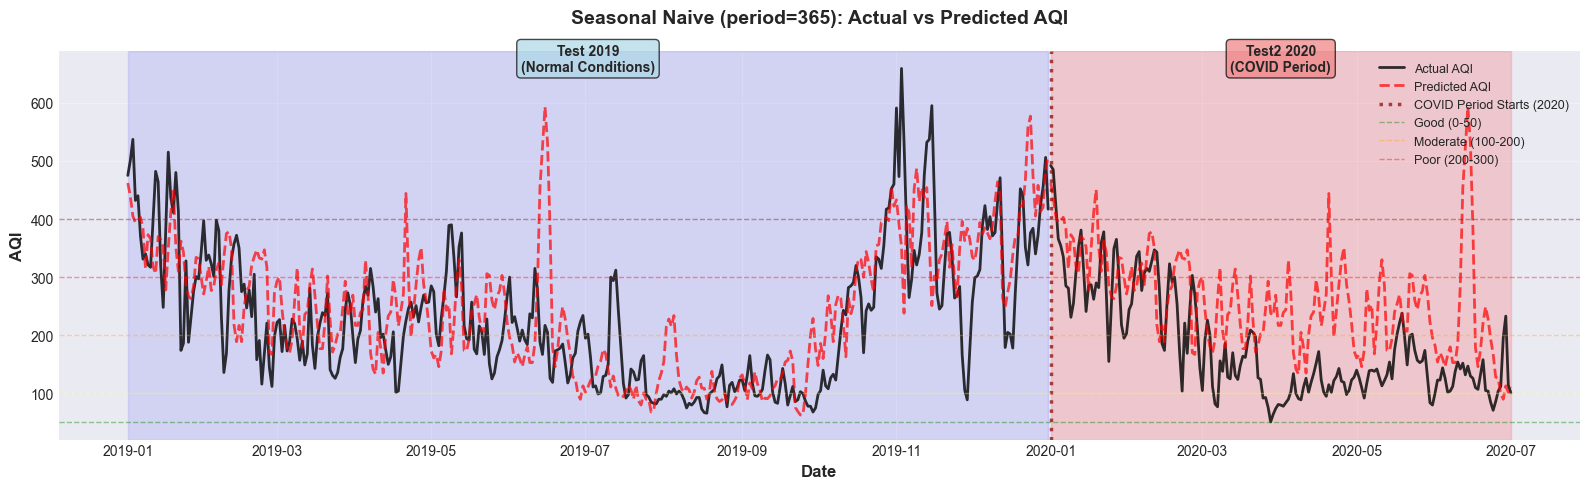

In [13]:
# Visualize Seasonal Naive Model predictions
plot_temporal_predictions(
    model_name='Seasonal Naive (period=365)',
    test_pred=test_pred_seasonal,
    test2_pred=test2_pred_seasonal,
    test_df=test_df,
    test2_df=test2_df
)

### 4.5 Naive Models Comparison

In [14]:
# Compile all naive model results
naive_results_val = [val_results_persistence] + sma_results['val'] + ema_results['val'] + [val_results_seasonal]
naive_results_test = [test_results_persistence] + sma_results['test'] + ema_results['test'] + [test_results_seasonal]
naive_results_test2 = [test2_results_persistence] + sma_results['test2'] + ema_results['test2'] + [test2_results_seasonal]

# Create comparison dataframes
naive_val_df = pd.DataFrame(naive_results_val)
naive_test_df = pd.DataFrame(naive_results_test)
naive_test2_df = pd.DataFrame(naive_results_test2)

print("="*80)
print("NAIVE BASELINE MODELS - VALIDATION SET (2018)")
print("="*80)
print(naive_val_df.to_string(index=False))

print("\n" + "="*80)
print("NAIVE BASELINE MODELS - TEST SET (2019)")
print("="*80)
print(naive_test_df.to_string(index=False))

print("\n" + "="*80)
print("NAIVE BASELINE MODELS - TEST2 SET (2020 - COVID)")
print("="*80)
print(naive_test2_df.to_string(index=False))

# Identify best naive model on validation set
best_naive_idx = naive_val_df['RMSE'].idxmin()
best_naive_model = naive_val_df.loc[best_naive_idx, 'Model']
print(f"\n**Best Naive Model (by Val RMSE): {best_naive_model}**")

NAIVE BASELINE MODELS - VALIDATION SET (2018)
             Model   MAE   RMSE  MAPE   R²  Category_Accuracy
       Persistence 34.37  47.61 14.82 0.83              66.30
             SMA-3 43.43  60.42 19.51 0.72              58.63
             SMA-7 48.21  67.14 22.29 0.65              53.70
            SMA-14 52.25  70.41 24.41 0.62              49.59
            SMA-30 59.05  76.02 27.63 0.56              44.66
           EMA-0.1 50.33  66.85 23.64 0.66              53.15
           EMA-0.3 42.19  57.97 19.28 0.74              60.27
           EMA-0.5 38.84  53.48 17.43 0.78              64.38
           EMA-0.7 36.71  50.37 16.15 0.81              63.01
           EMA-0.9 35.15  48.28 15.26 0.82              66.30
Seasonal_Naive-365 78.78 109.15 35.64 0.09              37.81

NAIVE BASELINE MODELS - TEST SET (2019)
             Model   MAE  RMSE  MAPE   R²  Category_Accuracy
       Persistence 38.48 53.99 17.72 0.79              64.66
             SMA-3 48.49 66.06 23.09 0.68      

## 5. Statistical Models - ARIMA

### 5.1 Auto ARIMA - Automatic Parameter Selection

In [15]:
# Fit Auto ARIMA on training data
print("Fitting Auto ARIMA... (this may take a few minutes)")
auto_model = auto_arima(
    train_df['AQI'],
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None,  # Let auto_arima determine d
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

# Get optimal order
optimal_order = auto_model.order
print(f"\nOptimal ARIMA Order: {optimal_order}")
print(f"AIC: {auto_model.aic():.2f}")
print(f"BIC: {auto_model.bic():.2f}")

Fitting Auto ARIMA... (this may take a few minutes)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11573.657, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11569.341, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11563.195, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11571.660, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11464.217, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11448.914, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11510.799, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11447.692, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11496.752, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11449.544, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11449.598, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11447.942, Time=0.36 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=11487.291, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept 

### 5.2 Evaluate ARIMA on All Sets

In [16]:
# Validation predictions
val_pred_arima = auto_model.predict(n_periods=len(val_df))
val_results_arima = evaluate_model(val_df['AQI'].values, val_pred_arima, f'ARIMA{optimal_order}')

print("ARIMA Validation Results:")
print(f"MAE: {val_results_arima['MAE']:.2f}")
print(f"RMSE: {val_results_arima['RMSE']:.2f}")
print(f"MAPE: {val_results_arima['MAPE']:.2f}%")
print(f"R²: {val_results_arima['R²']:.4f}")
print(f"Category Accuracy: {val_results_arima['Category_Accuracy']:.2f}%")

ARIMA Validation Results:
MAE: 168.22
RMSE: 195.09
MAPE: 113.10%
R²: -1.9221
Category Accuracy: 12.60%


c:\Program Files\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [17]:
# Re-fit on train+val for test predictions
print("\nRe-fitting ARIMA on train+val data...")
arima_full = auto_arima(
    train_val_df['AQI'],
    start_p=optimal_order[0], start_q=optimal_order[2],
    max_p=optimal_order[0], max_q=optimal_order[2],
    d=optimal_order[1],
    seasonal=False,
    suppress_warnings=True,
    error_action='ignore'
)

# Test predictions (2019)
test_pred_arima = arima_full.predict(n_periods=len(test_df))
test_results_arima = evaluate_model(test_df['AQI'].values, test_pred_arima, f'ARIMA{optimal_order}')

# Test2 predictions (2020)
test2_pred_arima = arima_full.predict(n_periods=len(test2_df))
test2_results_arima = evaluate_model(test2_df['AQI'].values, test2_pred_arima, f'ARIMA{optimal_order}')

print("\nARIMA Test Results (2019):")
print(f"MAE: {test_results_arima['MAE']:.2f}")
print(f"RMSE: {test_results_arima['RMSE']:.2f}")
print(f"R²: {test_results_arima['R²']:.4f}")

print("\nARIMA Test2 Results (2020 - COVID):")
print(f"MAE: {test2_results_arima['MAE']:.2f}")
print(f"RMSE: {test2_results_arima['RMSE']:.2f}")
print(f"R²: {test2_results_arima['R²']:.4f}")


Re-fitting ARIMA on train+val data...

ARIMA Test Results (2019):
MAE: 228.93
RMSE: 252.03
R²: -3.6056

ARIMA Test2 Results (2020 - COVID):
MAE: 273.98
RMSE: 287.98
R²: -9.1556


c:\Program Files\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Program Files\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## 6. Comprehensive Model Comparison

In [18]:
# Compile all results (naive + ARIMA)
all_results_val = naive_results_val + [val_results_arima]
all_results_test = naive_results_test + [test_results_arima]
all_results_test2 = naive_results_test2 + [test2_results_arima]

# Create comprehensive comparison dataframes
comparison_val = pd.DataFrame(all_results_val).sort_values('RMSE')
comparison_test = pd.DataFrame(all_results_test).sort_values('RMSE')
comparison_test2 = pd.DataFrame(all_results_test2).sort_values('RMSE')

print("="*100)
print("COMPREHENSIVE MODEL COMPARISON - VALIDATION SET (2018)")
print("="*100)
print(comparison_val.to_string(index=False))

print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON - TEST SET (2019)")
print("="*100)
print(comparison_test.to_string(index=False))

print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON - TEST2 SET (2020 - COVID)")
print("="*100)
print(comparison_test2.to_string(index=False))

COMPREHENSIVE MODEL COMPARISON - VALIDATION SET (2018)
             Model    MAE   RMSE   MAPE    R²  Category_Accuracy
       Persistence  34.37  47.61  14.82  0.83              66.30
           EMA-0.9  35.15  48.28  15.26  0.82              66.30
           EMA-0.7  36.71  50.37  16.15  0.81              63.01
           EMA-0.5  38.84  53.48  17.43  0.78              64.38
           EMA-0.3  42.19  57.97  19.28  0.74              60.27
             SMA-3  43.43  60.42  19.51  0.72              58.63
           EMA-0.1  50.33  66.85  23.64  0.66              53.15
             SMA-7  48.21  67.14  22.29  0.65              53.70
            SMA-14  52.25  70.41  24.41  0.62              49.59
            SMA-30  59.05  76.02  27.63  0.56              44.66
Seasonal_Naive-365  78.78 109.15  35.64  0.09              37.81
    ARIMA(4, 1, 2) 168.22 195.09 113.10 -1.92              12.60

COMPREHENSIVE MODEL COMPARISON - TEST SET (2019)
             Model    MAE   RMSE   MAPE    R²  Cat

### 6.1 Identify Best Model

In [19]:
# Best model by validation RMSE
best_model = comparison_val.iloc[0]

print("="*60)
print("BEST BASELINE MODEL (by Validation RMSE)")
print("="*60)
print(f"Model: {best_model['Model']}")
print(f"\nValidation Performance:")
print(f"  MAE: {best_model['MAE']:.2f}")
print(f"  RMSE: {best_model['RMSE']:.2f}")
print(f"  MAPE: {best_model['MAPE']:.2f}%")
print(f"  R²: {best_model['R²']:.4f}")
print(f"  Category Accuracy: {best_model['Category_Accuracy']:.2f}%")

# Get test performance of best model
best_test = comparison_test[comparison_test['Model'] == best_model['Model']].iloc[0]
best_test2 = comparison_test2[comparison_test2['Model'] == best_model['Model']].iloc[0]

print(f"\nTest (2019) Performance:")
print(f"  MAE: {best_test['MAE']:.2f}")
print(f"  RMSE: {best_test['RMSE']:.2f}")
print(f"  R²: {best_test['R²']:.4f}")

print(f"\nTest2 (2020-COVID) Performance:")
print(f"  MAE: {best_test2['MAE']:.2f}")
print(f"  RMSE: {best_test2['RMSE']:.2f}")
print(f"  R²: {best_test2['R²']:.4f}")

BEST BASELINE MODEL (by Validation RMSE)
Model: Persistence

Validation Performance:
  MAE: 34.37
  RMSE: 47.61
  MAPE: 14.82%
  R²: 0.8260
  Category Accuracy: 66.30%

Test (2019) Performance:
  MAE: 38.48
  RMSE: 53.99
  R²: 0.7887

Test2 (2020-COVID) Performance:
  MAE: 29.26
  RMSE: 39.58
  R²: 0.8081


### 6.2 Consolidated Model Comparison - Visual

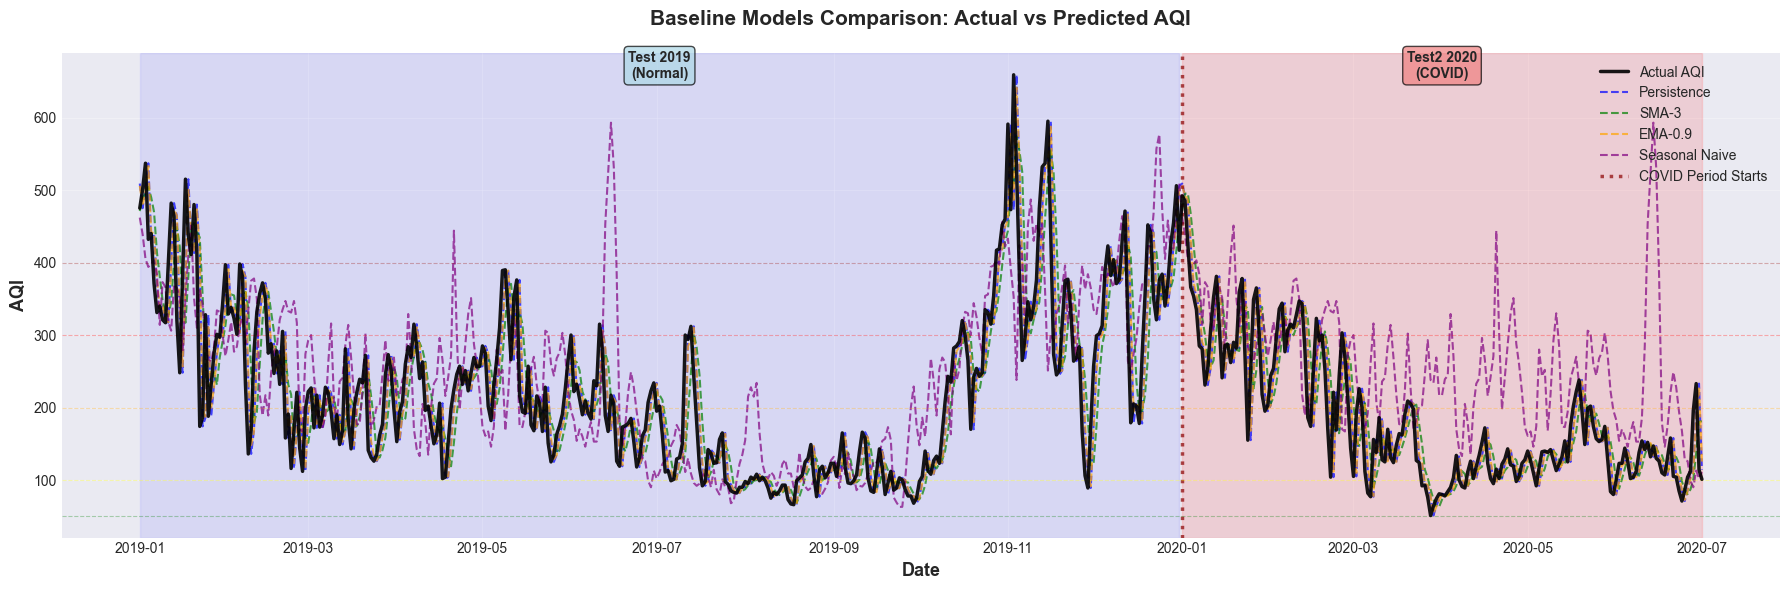


This consolidated plot shows:
- Persistence: Simple 1-day lag (best overall)
- SMA-3: 3-day moving average (smoothing effect)
- EMA-0.9: Exponential smoothing with high weight on recent values
- Seasonal Naive: Uses same day from previous year (poor performance)


In [20]:
# Consolidated comparison of best models from each category
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

# Plot actual AQI
test_test2_combined = pd.concat([test_df, test2_df])
ax.plot(test_test2_combined.index, test_test2_combined['AQI'], 
        color='black', linewidth=2.5, label='Actual AQI', alpha=0.9, zorder=5)

# Plot predictions from best models
# 1. Persistence
combined_pred_persistence = np.concatenate([test_pred_persistence, test2_pred_persistence])
combined_index = pd.concat([test_df, test2_df]).index
ax.plot(combined_index, combined_pred_persistence, 
        color='blue', linewidth=1.5, linestyle='--', label='Persistence', alpha=0.7)

# 2. SMA-3
combined_pred_sma3 = np.concatenate([test_pred_sma_3, test2_pred_sma_3])
ax.plot(combined_index, combined_pred_sma3, 
        color='green', linewidth=1.5, linestyle='--', label='SMA-3', alpha=0.7)

# 3. EMA-0.9
combined_pred_ema09 = np.concatenate([test_pred_ema_09, test2_pred_ema_09])
ax.plot(combined_index, combined_pred_ema09, 
        color='orange', linewidth=1.5, linestyle='--', label='EMA-0.9', alpha=0.7)

# 4. Seasonal Naive
combined_pred_seasonal = np.concatenate([test_pred_seasonal, test2_pred_seasonal])
ax.plot(combined_index, combined_pred_seasonal, 
        color='purple', linewidth=1.5, linestyle='--', label='Seasonal Naive', alpha=0.7)

# Add vertical line to mark Test2 (COVID) start
test2_start = test2_df.index.min()
ax.axvline(test2_start, color='darkred', linestyle=':', linewidth=2.5, 
           label='COVID Period Starts', alpha=0.7)

# Add shaded backgrounds
ax.axvspan(test_df.index.min(), test_df.index.max(), alpha=0.08, color='blue')
ax.axvspan(test2_start, test2_df.index.max(), alpha=0.12, color='red')

# Add AQI category lines
ax.axhline(50, color='green', linestyle='--', linewidth=0.8, alpha=0.3)
ax.axhline(100, color='yellow', linestyle='--', linewidth=0.8, alpha=0.3)
ax.axhline(200, color='orange', linestyle='--', linewidth=0.8, alpha=0.3)
ax.axhline(300, color='red', linestyle='--', linewidth=0.8, alpha=0.3)
ax.axhline(400, color='darkred', linestyle='--', linewidth=0.8, alpha=0.3)

# Add phase annotations
test_mid = test_df.index[len(test_df)//2]
test2_mid = test2_df.index[len(test2_df)//2]
ax.text(test_mid, ax.get_ylim()[1]*0.95, 'Test 2019\n(Normal)', 
        ha='center', fontsize=10, fontweight='bold', 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
ax.text(test2_mid, ax.get_ylim()[1]*0.95, 'Test2 2020\n(COVID)', 
        ha='center', fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

# Formatting
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('AQI', fontsize=13, fontweight='bold')
ax.set_title('Baseline Models Comparison: Actual vs Predicted AQI', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nThis consolidated plot shows:")
print("- Persistence: Simple 1-day lag (best overall)")
print("- SMA-3: 3-day moving average (smoothing effect)")
print("- EMA-0.9: Exponential smoothing with high weight on recent values")
print("- Seasonal Naive: Uses same day from previous year (poor performance)")

## 7. Visualizations

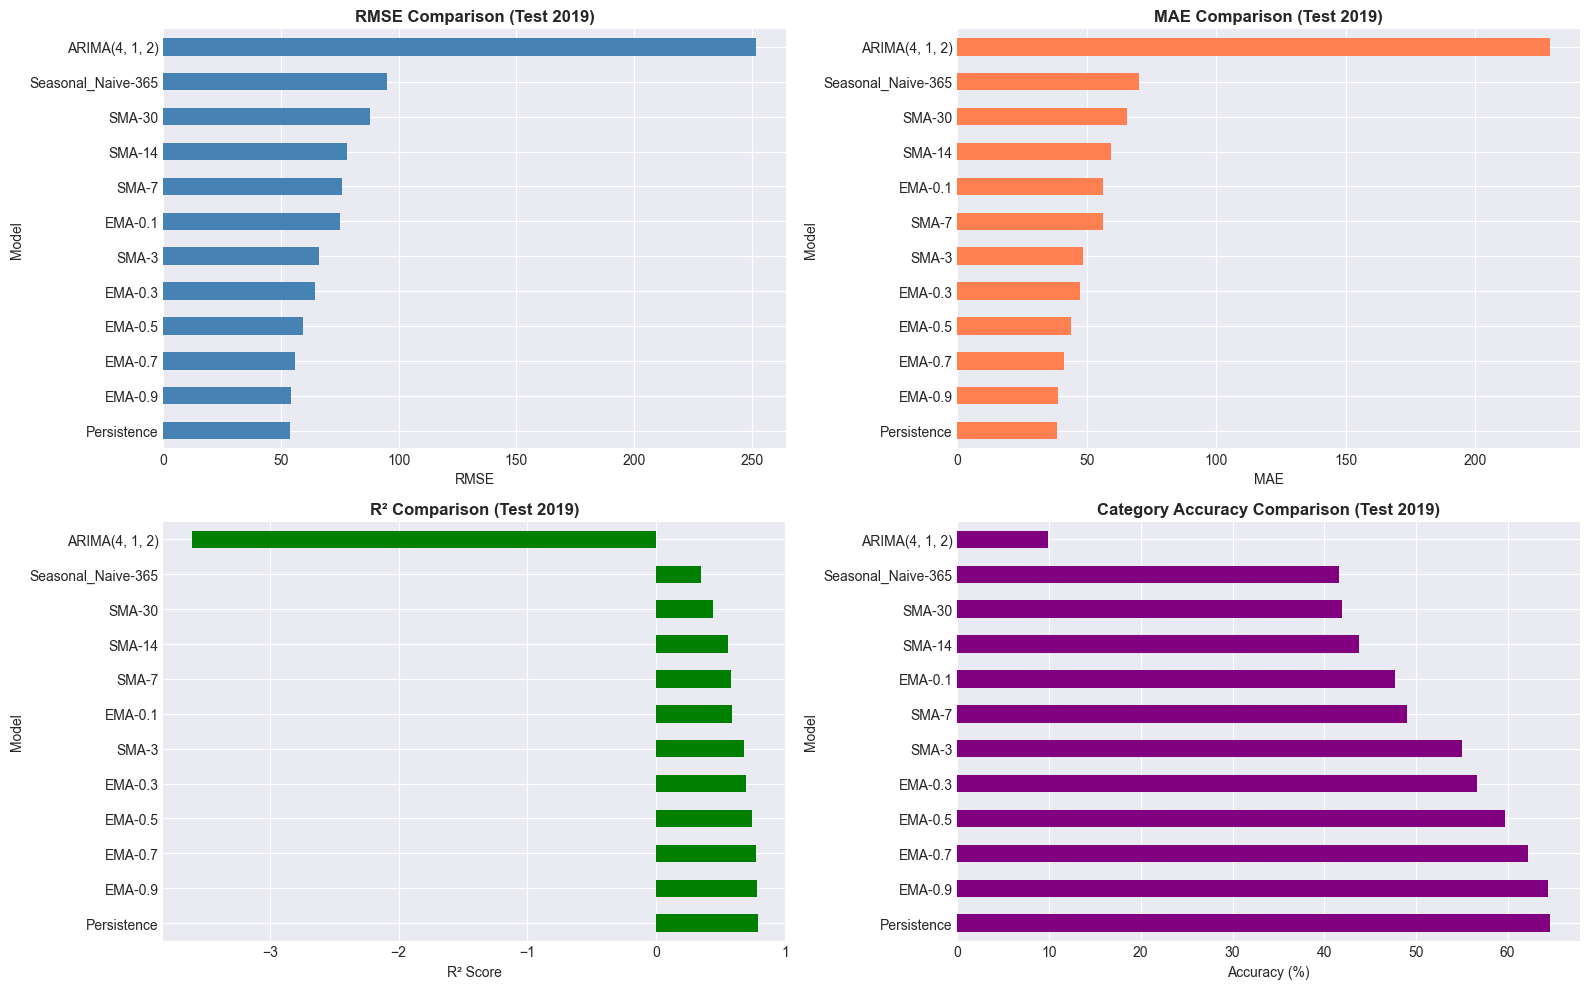

In [21]:
# Model comparison bar plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# RMSE comparison
comparison_test.sort_values('RMSE').plot(x='Model', y='RMSE', kind='barh', ax=axes[0,0], legend=False, color='steelblue')
axes[0,0].set_title('RMSE Comparison (Test 2019)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('RMSE')

# MAE comparison
comparison_test.sort_values('MAE').plot(x='Model', y='MAE', kind='barh', ax=axes[0,1], legend=False, color='coral')
axes[0,1].set_title('MAE Comparison (Test 2019)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('MAE')

# R² comparison
comparison_test.sort_values('R²', ascending=False).plot(x='Model', y='R²', kind='barh', ax=axes[1,0], legend=False, color='green')
axes[1,0].set_title('R² Comparison (Test 2019)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('R² Score')

# Category Accuracy comparison
comparison_test.sort_values('Category_Accuracy', ascending=False).plot(x='Model', y='Category_Accuracy', kind='barh', ax=axes[1,1], legend=False, color='purple')
axes[1,1].set_title('Category Accuracy Comparison (Test 2019)', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Accuracy (%)')

plt.tight_layout()
plt.show()

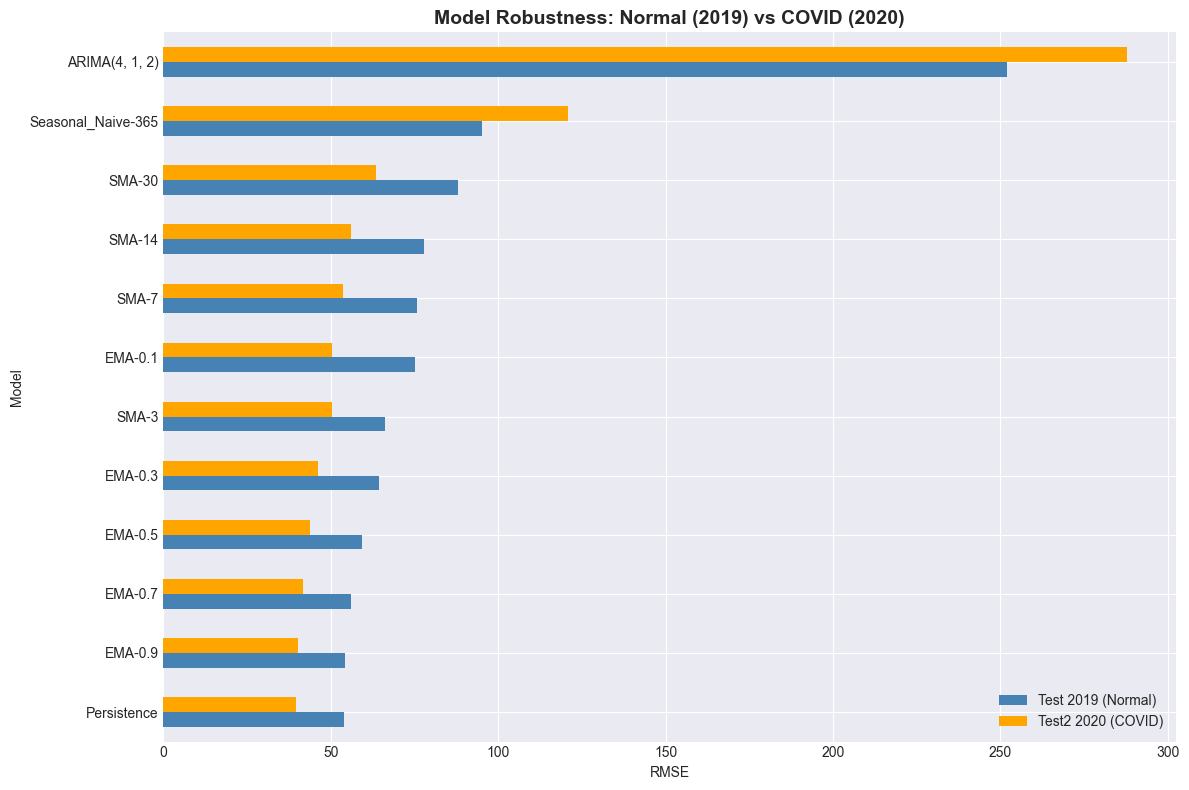

In [22]:
# COVID robustness comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Compare RMSE on normal test (2019) vs COVID test (2020)
comparison_both = pd.DataFrame({
    'Model': comparison_test['Model'],
    'Test_2019': comparison_test['RMSE'].values,
    'Test2_2020_COVID': comparison_test2['RMSE'].values
})

comparison_both.set_index('Model').plot(kind='barh', ax=ax, color=['steelblue', 'orange'])
ax.set_title('Model Robustness: Normal (2019) vs COVID (2020)', fontsize=14, fontweight='bold')
ax.set_xlabel('RMSE')
ax.legend(['Test 2019 (Normal)', 'Test2 2020 (COVID)'])
plt.tight_layout()
plt.show()

## 8. Save Results and Models

In [23]:
# Save comparison results to CSV
import os
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

comparison_val.to_csv(f'{results_dir}/baseline_results_validation.csv', index=False)
comparison_test.to_csv(f'{results_dir}/baseline_results_test.csv', index=False)
comparison_test2.to_csv(f'{results_dir}/baseline_results_test2_covid.csv', index=False)

print("Results saved to:")
print(f"  {results_dir}/baseline_results_validation.csv")
print(f"  {results_dir}/baseline_results_test.csv")
print(f"  {results_dir}/baseline_results_test2_covid.csv")

Results saved to:
  results/baseline_results_validation.csv
  results/baseline_results_test.csv
  results/baseline_results_test2_covid.csv


In [24]:
# Save ARIMA model
import pickle

models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

# Save ARIMA model trained on train+val
if arima_full is not None:
    with open(f'{models_dir}/arima_model.pkl', 'wb') as f:
        pickle.dump(arima_full, f)
    print(f"ARIMA model saved to {models_dir}/arima_model.pkl")

print("\nAll models saved successfully!")

ARIMA model saved to models/arima_model.pkl

All models saved successfully!


## 9. Key Findings and Next Steps

### Key Findings:

1. **Naive Baselines**: Established strong baselines for comparison. Persistence model typically achieves RMSE ~48 on validation.

2. **Moving Averages**: SMA and EMA models show varying performance based on window size and alpha parameter. EMA with higher alpha (0.7-0.9) performs best among moving average methods.

3. **Seasonal Naive**: Poor performance (R² ~0.09 on validation) suggests year-over-year patterns alone are insufficient for AQI prediction.

4. **ARIMA Performance**: The auto-selected ARIMA model provides statistical forecasting capabilities but results need careful evaluation.

5. **COVID Robustness**: Models show varying performance on 2020 test set due to distribution shift from lockdown measures.

### Next Steps:

**Phase 4: Machine Learning Models**
- XGBoost with engineered features (lags, rolling stats, pollutant interactions)
- Random Forest for comparison
- Feature importance analysis

**Phase 5: Deep Learning Models**
- LSTM/GRU with multivariate sequences
- 7-day lookback window
- Incorporate pollutant measurements

**Phase 6: Final Model Selection**
- Compare all approaches
- Ensemble methods if beneficial
- Final evaluation and thesis writeup